# AESA/PESA Radar Simulation Demo

This demonstration simulates data from a **Doppler radar** and, eventually, a **PESA radar**.  
The goal is to use machine learning to estimate:

- **Location**
- **Speed**
- **Distance** of a target

While this approach is slower than mathematical solutions, it aims to provide an *open-source* alternative that is transparent and accessible.

## Purpose

- Assist in developing small radar systems to protect tanks/IFVs.
- Address threats like drones cost-effectively.
- Enable processing with a small computer and radar installation.

*Prototype development will follow later.*

In [1]:
#!/usr/bin/env python3
# Imports 
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import random, math
from scipy.signal import hilbert
from scipy.fft import fft, fftfreq


we store our freuqencies within a hashmap as tuples to be able to more finely constrain wavelength

In [2]:
frequency_bands = {
    "L":  (1e9, 2e9),        # 1 – 2 GHz
    "S":  (2e9, 4e9),        # 2 – 4 GHz
    "C":  (4e9, 8e9),        # 4 – 8 GHz
    "X":  (8e9, 12e9),       # 8 – 12 GHz
    "Ku": (12e9, 18e9),      # 12 – 18 GHz
    "Ka": (26.5e9, 40e9)     # 26.5 – 40 GHz
}

def getFrequency(frequencyBand: str) -> float:
    if frequencyBand in frequency_bands:
        f_min, f_max = frequency_bands[frequencyBand]
        return random.uniform(f_min, f_max)
    else:
        raise ValueError("unknown frequency band")


#### Create our dataclasses for the radar
- a basic target and radar MVP for our caluclations


In [3]:
# --- Target struct---
@dataclass
class Target:
    name: str             # Target name - e.g. "SU-33"
    classification: str   # e.g. "drone/aircraft/helicopter"
    position: np.ndarray  # [x, y, z] meters
    rcs: float            # Radar cross-section (sigma)
    velocity: np.ndarray = np.array([0.0, 0.0, 0.0])  # m/s

# --- Radar struct---
@dataclass
class Radar:
    name: str                # Radar name (brand)
    position: np.ndarray       # Radar position [x, y, z]
    frequency: float           # Radar frequency (Hz)
    transmitted_power: float   # Transmit power (W)
    antenna_gain: float        # Antenna gain (linear)

    def get_elucidianDistance(self, target: Target) -> float:
        """Calculate elucid distance between radar and target using numpy linear algebra"""
        return np.linalg.norm(target.position - self.position) 
    
    def getTimeDelay(self, target: Target) -> float:
        """Calculate time delay for signal to travel to target and back (delta T)"""
        c = 3e8
        return 2 * self.get_elucidianDistance(target) / c
    
    def getRecievedPower(self, target: Target) -> float:
        """Calculate the received power using the radar equation"""
        c = 3e8 # speed of light
        Pt = self.transmitted_power
        G = self.antenna_gain
        lambda_ =  c / self.frequency
        sigma = target.rcs
        R = self.get_elucidianDistance(target)
        L = 1 # System losses (assumed to be 1 for simplicity)
        return (Pt * G**2 * lambda_**2 * sigma) / ((4 * math.pi)**3 * R**4 * L)
    
    def simulate_ping(self, target: Target, duration=1e-4, sample_rate=1e7, noise_power=1e-10):
        t = np.arange(0, duration, 1/sample_rate)
        c = 3e8
        f_c = self.frequency
        
        # Line-of-sight velocity
        R_vec = target.position - self.position
        R_hat = R_vec / np.linalg.norm(R_vec)
        v_los = np.dot(target.velocity, R_hat)  # m/s along line-of-sight
        
        # Doppler shift
        lambda_ = c / f_c
        f_D = 2 * v_los / lambda_
        
        # Time delay
        delay = self.getTimeDelay(target)
        
        # Received power
        Pr = self.getRecievedPower(target)
        
        # Define pulse
        pulse_duration = 1e-6  # 1 µs pulse
        echo = np.zeros_like(t)

        # Convert delay and pulse duration to sample indices
        delay_samples = int(round(delay * sample_rate))
        pulse_samples = int(round(pulse_duration * sample_rate))

        start = max(0, delay_samples - pulse_samples // 2)
        end   = min(len(t), delay_samples + pulse_samples // 2)

        # Apply pulse
        echo[start:end] = np.sqrt(Pr)  # no high-frequency cosine

        # Add Gaussian noise
        noise = np.random.normal(0, np.sqrt(noise_power), size=t.shape)
        received_signal = echo + noise

        return t, received_signal



### Creating our radar and target 
#### Here we create our radar and target variables, we are using data referenced from wikipedia at 
*https://en.wikipedia.org/wiki/AN/SPY-1*

In [4]:
radar = Radar(
    name="AN/SPY-1",
    position=np.array([0, 0, 0]),   # Radar at origin (x=0, y=0, z=0)
    frequency=getFrequency("S"),    # Use the key from frequency_bands
    transmitted_power=4e6,          # 4 MW (peak power)
    antenna_gain=10**(42/10)        # Convert dB to linear scale
)

target = Target(
    name="SU-33",
    classification="aircraft",
    position=np.array([6000, 0, 0]),  # 6 km in front of origin (x=0, y=0, z=0)
    rcs=10.0,                         # Example RCS in m² (fighter-sized target)
    velocity=np.array([200, 0, 0])    # 200 m/s along x-axis 
)


# Basic PD range estimation (without doppler shift)

In [8]:
# Simulate radar ping

pings = 10000
PRI = 1e-3  # 1 ms between pings
ping_times = []  # store absolute time of each ping
current_time = 0  # start at t=0

returns = []
ranges = []
envelopes = []
# simulate time over multiple pings (add a pri)
for _ in range(pings):
    # Simulate ping
    t, received_signal = radar.simulate_ping(
        target,
        duration=1e-4, 
        sample_rate=1e7, 
        noise_power=1e-10
    )
    returns.append((t, received_signal))

    # Record the absolute ping time
    ping_times.append(current_time)
    current_time += PRI  # move time forward by PRI

    # Update target position for next ping
    target.position = target.position.astype(float) + target.velocity * PRI


    # Compute envelope
    analytic_signal = hilbert(received_signal)
    envelope = np.abs(analytic_signal)

    # Find peak after minimum range
    c = 3e8
    min_range = 1
    min_idx = int((2 * min_range / c) * 1e7)
    peak_idx = np.argmax(envelope[min_idx:]) + min_idx
    t_peak = t[peak_idx]
    target_range = c * t_peak / 2

    envelopes.append(envelope)
    ranges.append(target_range)


## Here we will plot the data using matplotlib 
#### Please remember to reset target and radar after testing as target distance will become uncanny

final real target position: [10000.     0.     0.]
final target position accuracy: 0.645802285100987 m
Estimated radial speed: 201.02 m/s
Real target velocity: [200   0   0]
innacuracy % is: 0.645802285100987


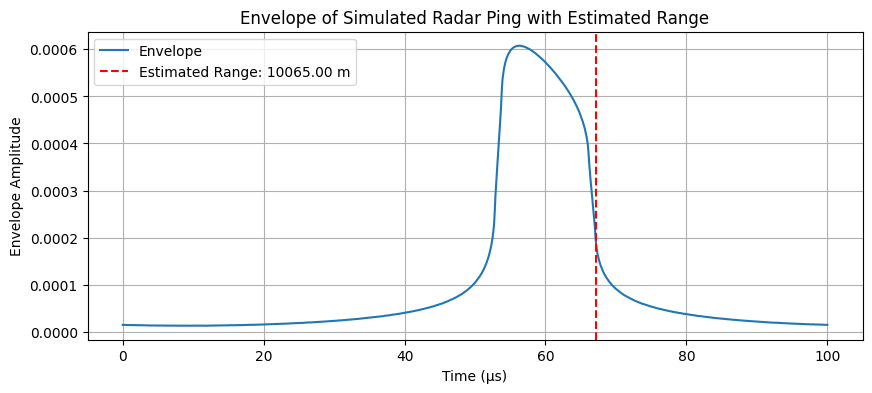

In [9]:
# calculate absolute error for x,y,z 
ranges_m = np.array(ranges)
ping_times = np.array(ping_times)

radial_velocity = (ranges_m[-1] - ranges_m[0]) / (ping_times[-1] - ping_times[0])
ranges_m = [c * t_peak / 2 for t_peak in ranges]  # in meters

# Position inaccuracy (using x-component)
inaccuracy_pos = abs(target.position[0] - target_range) / target_range * 100

# Velocity inaccuracy (using x-component)
inaccuracy_vel = abs(target.velocity[0] - radial_velocity) / abs(radial_velocity) * 100
mean_envelope = np.mean(envelopes, axis=0)

print(f"final real target position: {target.position}")
print(f"final target position accuracy: {inaccuracy_pos} m")

print(f"Estimated radial speed: {radial_velocity:.2f} m/s")
print(f"Real target velocity: {target.velocity}")
print(f"innacuracy % is: {inaccuracy_pos}")


# Plot the envelope and mark estimated range
plt.figure(figsize=(10,4))
plt.plot(t*1e6, mean_envelope, label='Envelope')
plt.axvline(t_peak*1e6, color='r', linestyle='--', 
            label=f'Estimated Range: {target_range:.2f} m')
plt.xlabel("Time (µs)")
plt.ylabel("Envelope Amplitude")
plt.title("Envelope of Simulated Radar Ping with Estimated Range")
plt.grid(True)
plt.legend()
plt.show()